In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

from matplotlib import pyplot as plt
from dotenv import load_dotenv

from scripts.merge import merge_cols, complete_df
from scripts.convert import convert_to_holy_metric, find_unit

load_dotenv()
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


# <u>Pre Cleaning : </u>

<u>Objectifs :</n>

1. Formatter les données
2. Identifier et retenir les variables indispensables à l'analyse et la construction de modeles predictifs
3. Convertir les données au format metrique/internationnal (base 10)
4. Deuxieme passe sur les variables : duplicatas, pertinence, variables contenant beaucoup de valeurs nulles
5. Exporter un dataset pret pour une analyse exploratoire

## <u> 1. Formattage des données </u>

In [71]:
# Files

twenty_fifteen_bm = "data/2015-building-energy-benchmarking.csv"
twenty_sixteen_bm = "data/2016-building-energy-benchmarking.csv"


In [72]:
df_fifteen = pd.read_csv(twenty_fifteen_bm, dtype="unicode", low_memory=False)
df_sixteen = pd.read_csv(twenty_sixteen_bm, dtype="unicode", low_memory=False)


In [73]:
print("info : ", df_fifteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   OSEBuildingID                                                  3340 non-null   object
 1   DataYear                                                       3340 non-null   object
 2   BuildingType                                                   3340 non-null   object
 3   PrimaryPropertyType                                            3340 non-null   object
 4   PropertyName                                                   3340 non-null   object
 5   TaxParcelIdentificationNumber                                  3338 non-null   object
 6   Location                                                       3340 non-null   object
 7   CouncilDistrictCode                                            3340 n

In [74]:
print("info : ", df_sixteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   OSEBuildingID                    3376 non-null   object
 1   DataYear                         3376 non-null   object
 2   BuildingType                     3376 non-null   object
 3   PrimaryPropertyType              3376 non-null   object
 4   PropertyName                     3376 non-null   object
 5   Address                          3376 non-null   object
 6   City                             3376 non-null   object
 7   State                            3376 non-null   object
 8   ZipCode                          3360 non-null   object
 9   TaxParcelIdentificationNumber    3376 non-null   object
 10  CouncilDistrictCode              3376 non-null   object
 11  Neighborhood                     3376 non-null   object
 12  Latitude                         3

In [75]:
id_fifteen_list = list(df_fifteen["OSEBuildingID"])
id_sixteen_list = list(df_sixteen["OSEBuildingID"])

only_in_fifteen = [ident for ident in id_fifteen_list if ident not in id_sixteen_list]
only_in_sixteen = [ident for ident in id_sixteen_list if ident not in id_fifteen_list]

print(
    f"""{len(only_in_fifteen)} batiments ne sont présents que dans le benchmark 2015,\
 et {len(only_in_sixteen)} batiments ne sont présents que dans le benchmark 2016 """
  )


56 batiments ne sont présents que dans le benchmark 2015, et 92 batiments ne sont présents que dans le benchmark 2016 


In [76]:
col_onl_fifteen = [col for col in df_fifteen.columns if col not in df_sixteen.columns]

col_onl_sixteen = [col for col in df_sixteen.columns if col not in df_fifteen.columns]

print("Nombre de variables non communes aux deux datasets : ", len(col_onl_fifteen) + len(col_onl_sixteen))


Nombre de variables non communes aux deux datasets :  19


In [77]:
print(col_onl_sixteen)


['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [78]:
print(col_onl_fifteen)


['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes']


In [79]:
df_fifteen["Location"].describe().top


'{\'latitude\': \'47.52593209\', \'longitude\': \'-122.3308402\', \'human_address\': \'{"address": "309 S CLOVERDALE ST", "city": "SEATTLE", "state": "WA", "zip": "98108"}\'}'

### Observations :

- Plusieurs batiments ne sont pas communs aux deux datasets, on utilsera par defaut les informations les plus recentes (2016), et on importera les données manquantes

## 2.1 : Premier filtrage des variables inutiles & formatage des labels des variables
- Certaines colonnes ne sont presentes que dans le dataset 2015, ces variables seront supprimées (droplist), d'autres ont un nom different et seront renommées
- Les deux datasets mentionnent la presence d'outliers, mais les metadonnees n'informent pas ce qui les determinent. Suppression des outliers.
- Les données de localisation de l'annee 2015 sont presentes au format d'un dictionnaire, format plus efficace que les nombreuses variables de 2016. On pourra compresser les donnees de 2016 pour obtenir ce format
- Certaines colonnes sont inutiles a l'etude et a la construction d'un modele mais apportent des informations interessantes sur les batiments si le besoin est. --> Creation d'un dataset Meta

In [80]:
# Outliers :

df_sixteen = df_sixteen[df_sixteen["Outlier"].isna()]
df_fifteen = df_fifteen[df_fifteen["Outlier"].isna()]


In [81]:
rename_sixteen = {
    "Comments": "Comment",
    "TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)",
    "GHGEmissionsIntensity": "GHGEmissionsIntensity(kgCO2e/ft2)",
    }

droplist = [
    "Zip Codes", "Zipcode", "SPD Beats", "2010 Census Tracts", "City Council Districts",
    "Seattle Police Department Micro Community Policing Plan Areas", "OtherFuelUse(kBtu)",  # OtherFuelUse not present in both datasets
    "SPD Beats", "CouncilDistrictCode", "Outlier", "DataYear", "ZipCode", "NaturalGas(therms)",  # Natural gas already present in another unit
    ]

# Columns not relevant to study but informative on the properties
meta_df_cols = [
    "TaxParcelIdentificationNumber", "YearsENERGYSTARCertified", "Comment", "Location", "OSEBuildingID",
    "PrimaryPropertyType", "PropertyName", "YearBuilt"
    ]

meta_keep = ["OSEBuildingID", "PrimaryPropertyType", "PropertyName", "YearBuilt"]

compress_cols = ["Address", "City", "State", "Latitude", "Longitude"]


In [82]:
df_fifteen = df_fifteen.drop(columns=droplist, errors="ignore")
df_sixteen = df_sixteen.drop(columns=droplist, errors="ignore")


In [83]:
# Using 2015 synthax, compression of compress cols & placing data in new col

df_sixteen["Location"] = np.nan

merge_cols(origin_col_list=compress_cols, target_col_name="Location", dataframe=df_sixteen)

df_sixteen.drop(columns=compress_cols, inplace=True)


In [84]:
# renaming cols for merger

df_sixteen.rename(columns=rename_sixteen, inplace=True)

for col in df_sixteen.columns:
    if col not in df_fifteen.columns:
        raise BaseException("Mismatch")


## 2.2 : Fusion des dataframes, ajout des batiments non presents dans le dataset 2016

In [85]:
# merging : 
to_merge = df_fifteen[df_fifteen["OSEBuildingID"].isin(only_in_fifteen)]

df_seattle = pd.concat([df_sixteen, to_merge])

if len(df_seattle[df_seattle.duplicated()]) > 0:
    print("Duplicates, edit code ...")
else:
    print("No duplicate, merger ok")


No duplicate, merger ok


In [86]:
# Created 2 meta dataframes and dropped the cols in main dfs

meta_df_fifteen = df_fifteen[meta_df_cols]
meta_df_sixteen = df_sixteen[meta_df_cols]

meta_drop = [col for col in meta_df_cols if col not in meta_keep]

df_fifteen.drop(columns=meta_drop, inplace=True)
df_sixteen.drop(columns=meta_drop, inplace=True)
df_seattle.drop(columns=meta_drop, inplace=True)


## 2.3 : Identification et suppression des batiments residentiels : 
- L'etude et les modeles ne se concentreront que sur les batiments non residentiels
- Identification et suppression


In [87]:
btypes_fifteen = list(df_fifteen["BuildingType"].unique())
btypes_sixteen = list(df_sixteen["BuildingType"].unique())

btypes_both = btypes_fifteen
[btypes_both.append(btype) for btype in btypes_sixteen if btype not in btypes_both]

print(btypes_both)


['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus', 'Multifamily HR (10+)', 'Nonresidential WA']


In [88]:
# Residential startswith multifamily

residential = [btype for btype in btypes_both if (str(btype).lower().startswith("multifamily") or str(btype).lower().endswith("multifamily"))]
print(residential)


['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']


In [89]:
# Dropping residential

df_seattle = df_seattle[~df_seattle["BuildingType"].isin(residential)]

# Check : 

btype_after_pass = list(df_seattle["BuildingType"].unique())

for btype in btype_after_pass:
    if btype in residential:
        print("Suppression Failed, advise")
        break
    
print("Suppression OK")


Suppression OK


In [90]:
# Double checking in property types :

print(df_seattle["PrimaryPropertyType"].unique())


['Hotel' 'Other' 'Mixed Use Property' 'K-12 School' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'Large Office' 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital' 'Residence Hall' 'Distribution Center' 'Worship Facility'
 'Supermarket / Grocery Store' 'Laboratory' 'Refrigerated Warehouse'
 'Restaurant' 'Low-Rise Multifamily' 'Office' 'Non-Refrigerated Warehouse'
 'Restaurant\n']


In [91]:
# 1propertytypes contains residential, cleaning :

ptypes_res = ["Low-Rise Multifamily"]
df_seattle = df_seattle[~df_seattle["PrimaryPropertyType"].isin(ptypes_res)]


## 3 : Conversion systeme imperial --> Systeme metrique internationnal

- Unités concernées :
    - Energie non au format W ou J
    - Tailles et distances exprimées en pieds


In [92]:
# Convert

unit_stop_chars = ["(", ")", "GFA"]

manual_ignore = ["Electricity(kWh)", "GHGEmissions(MetricTonsCO2e)", "GHGEmissionsIntensity(kgCO2e/ft2)"]

unit_cols = [col for col in df_seattle.columns if (any(char in col for char in unit_stop_chars) and col not in manual_ignore)]


In [93]:
unit_dict = dict.fromkeys(unit_cols)

for col in unit_dict.keys(): 
    unit = find_unit(var_name=col, convert=True)["converted_unit"]

    if "GFA" in col:
        new_name = col.replace("GFA", "Area(SquareMetre)")
    elif ("("and ")") in col:
        start, end = col.find("("), col.find(")")
        before = col[:start + 1]
        after = col[end:]
        new_name = f"{before}{unit}{after}"
    
    df_seattle[new_name] = np.nan
    unit_dict[col] = new_name

for key, value in unit_dict.items():

    for index, series in df_seattle.iterrows():
        df_seattle.at[index, value] = convert_to_holy_metric(data=series[key], var_name=key)

df_seattle.drop(columns=unit_dict.keys(), inplace=True)


## 4. Deuxieme passe sur les variables

In [94]:
df_seattle.columns


Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'Electricity(kWh)', 'DefaultData',
       'ComplianceStatus', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'PropertyArea(SquareMetre)Total',
       'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)',
       'SecondLargestPropertyUseTypeArea(SquareMetre)',
       'ThirdLargestPropertyUseTypeArea(SquareMetre)', 'SiteEUI(kWh/m2)',
       'SiteEUIWN(kWh/m2)', 'SourceEUI(kWh/m2)', 'SourceEUIWN(kWh/m2)',
       'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)', 'SteamUse(kWh)',
       'NaturalGas(kWh)'],
      dtype='object')

In [95]:
# EPA has determined that source energy is the most equitable [...] cf. sources
# |^| removing cols starting with site, except SiteEnergyUse(kWh) (no SourceXYZ)

ignore_site = ["SiteEnergyUse(kWh)", "SiteEnergyUseWN(kWh)"]

site_cols = [col for col in df_seattle.columns if (col.startswith("Site") and col not in ignore_site)]
df_seattle.drop(columns=site_cols, inplace=True)


### 4.1 On peut constater la presence de variables concernant l'utilisation de la vapeur et des gazs naturels
- De moins en moins de batiments utilisent !directement! le gaz naturel, variable significative ?
- Idem dans le cas de la vapeur

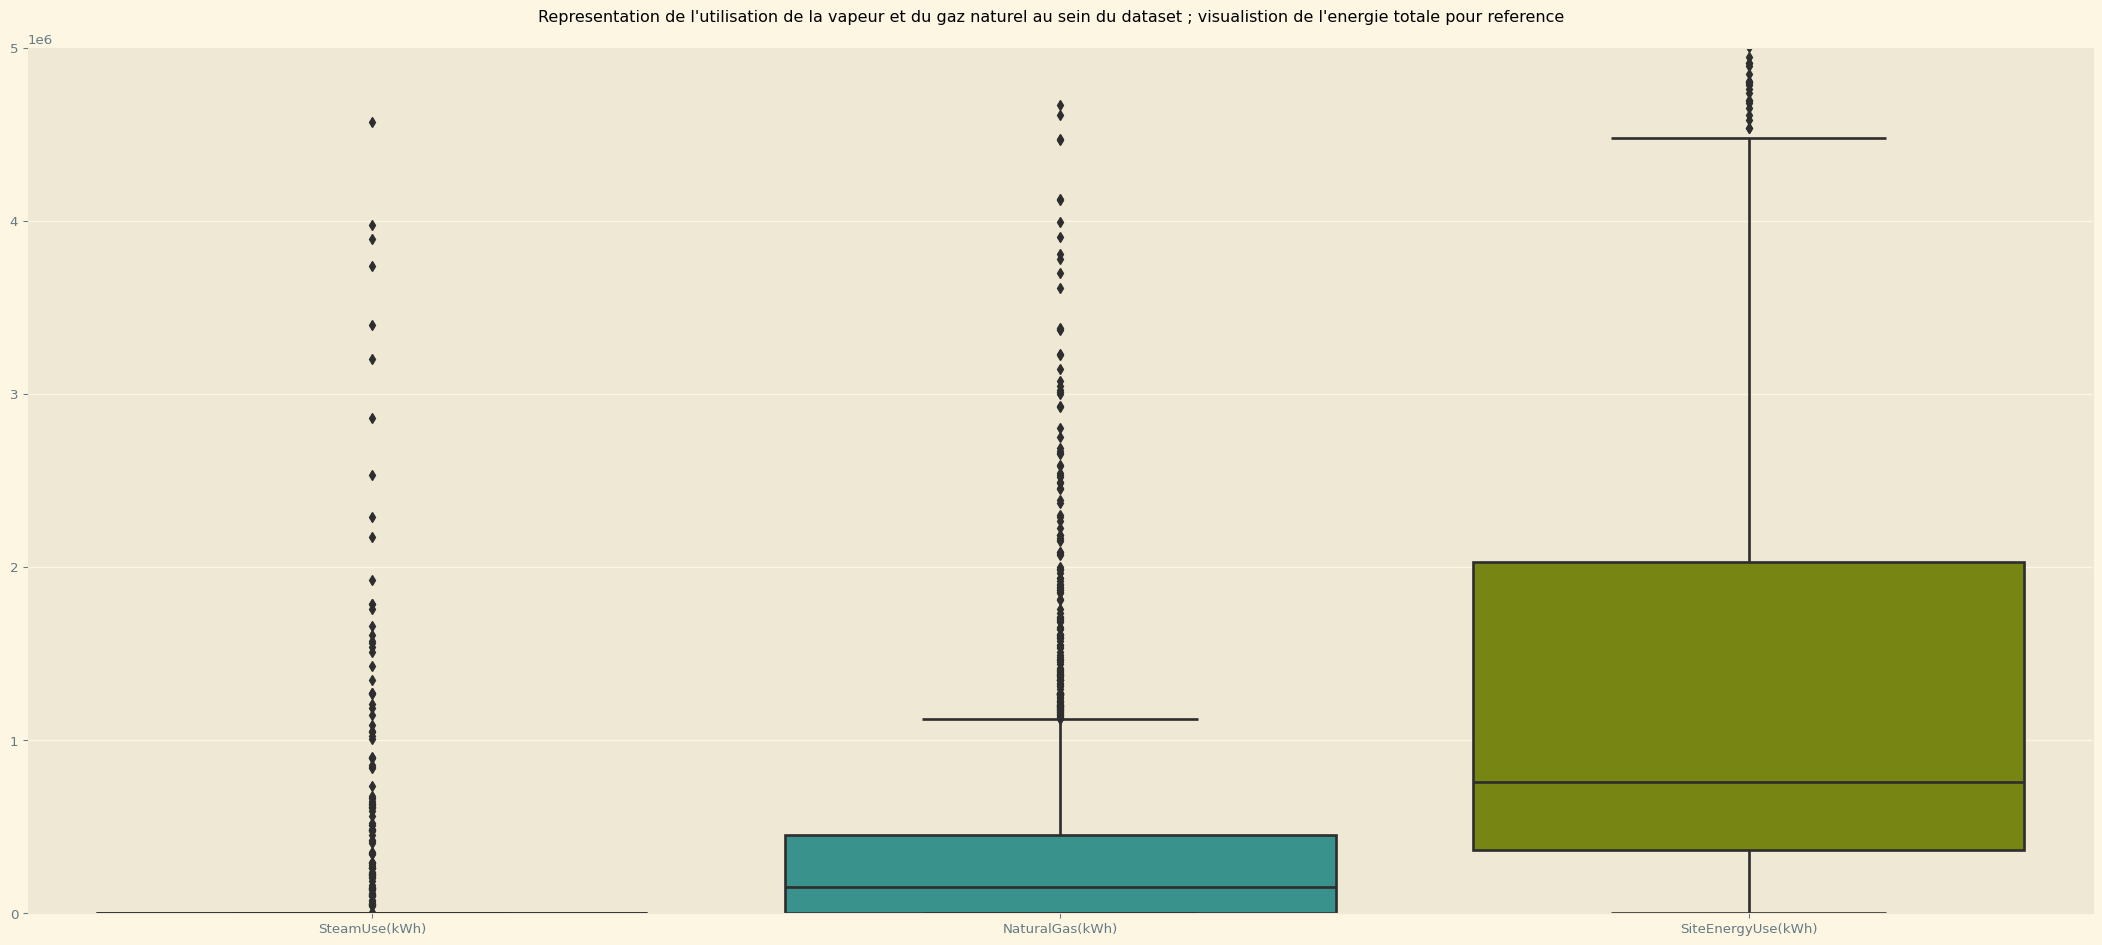

In [96]:
# Steam and Natural gas might be uncommon - Plotting ...

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.boxplot(
    data=df_seattle[["SteamUse(kWh)", "NaturalGas(kWh)", "SiteEnergyUse(kWh)"]]
)


###
# Titles/Lables
ax1.set_ylim(0, 0.5 * 1e7)
fig.suptitle("Representation de l'utilisation de la vapeur et du gaz naturel au sein du dataset\
 ; visualistion de l'energie totale pour reference")
#
###
fig.tight_layout()
plt.show()


In [97]:
df_seattle.drop(columns=["SteamUse(kWh)"], inplace=True)


In [98]:
df_seattle.columns


Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'Electricity(kWh)', 'DefaultData',
       'ComplianceStatus', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'PropertyArea(SquareMetre)Total',
       'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)',
       'SecondLargestPropertyUseTypeArea(SquareMetre)',
       'ThirdLargestPropertyUseTypeArea(SquareMetre)', 'SourceEUI(kWh/m2)',
       'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)',
       'NaturalGas(kWh)'],
      dtype='object')

### 4.2 : Taux de valeurs manquantes, deuxieme passe sur les variables

In [99]:
nans_cols = dict.fromkeys(df_seattle.columns)

total_buildings = len(df_seattle)

for col in nans_cols.keys():
    nans_cols[col] = f"{(df_seattle[col].isna().sum() / total_buildings) * 100}%"
    if (df_seattle[col].isna().sum() / total_buildings) > 0.05:
        print(col, "=", nans_cols[col], "(!!!)")
    else: 
        print(col, "=", nans_cols[col])


OSEBuildingID = 0.0%
BuildingType = 0.0%
PrimaryPropertyType = 0.0%
PropertyName = 0.0%
Neighborhood = 0.0%
YearBuilt = 0.0%
NumberofBuildings = 0.11926058437686345%
NumberofFloors = 0.0%
ListOfAllPropertyUseTypes = 0.4770423375074538%
LargestPropertyUseType = 0.7155635062611807%
SecondLargestPropertyUseType = 48.837209302325576% (!!!)
ThirdLargestPropertyUseType = 78.9505068574836% (!!!)
ENERGYSTARScore = 34.46630888491354% (!!!)
Electricity(kWh) = 0.17889087656529518%
DefaultData = 0.0%
ComplianceStatus = 0.0%
GHGEmissions(MetricTonsCO2e) = 0.17889087656529518%
GHGEmissionsIntensity(kgCO2e/ft2) = 0.17889087656529518%
PropertyArea(SquareMetre)Total = 0.0%
PropertyArea(SquareMetre)Parking = 0.0%
PropertyArea(SquareMetre)Building(s) = 0.0%
LargestPropertyUseTypeArea(SquareMetre) = 0.9540846750149076%
SecondLargestPropertyUseTypeArea(SquareMetre) = 48.89683959451401% (!!!)
ThirdLargestPropertyUseTypeArea(SquareMetre) = 78.9505068574836% (!!!)
SourceEUI(kWh/m2) = 0.17889087656529518%
Sour

#### Observation : 
- 34+% des batiments du dataset n'ont pas de note E* --> Cette note servira de baseline pour tout modele et analyse - Les batiments n'etant pas notés seront supprimés
- Nombreuses repetitions (Total, Parking, Building) --> On s'interesse au totaux
- SourceEUI est une des données les plus importantes du dataset, le site E* s'interesse majoritairement à cette statistique, les batiments pour lesquels cette statistique est nulle seront egalement supprimés
- Ont peut noter egalement Electricity et emissions de GAES (GHG) comme variable importante --> meme traitement
- Les valeurs ayant le suffixe WN signifient Weather Normalized, cette variable a son importance : certains materiaux et methodes de construction sont importantes dans la gestion de l'energie, ce qui aboutis à des batiments plus 'propres' ==> Ces methodes et materiaux addressent des problemes comme le transfert de temperature interieur exterieur (climate control) etc.

<i>Note : Le taux de valeurs manquantes pour certaines variables est très similaire : 0.1786777843954735% : Ce sont potentiellement les memes batiments</i>

In [100]:
manual_drop = [
    "ListOfAllPropertyUseTypes", "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType", "DefaultData", "ComplianceStatus",
    "SecondLargestPropertyUseTypeArea(SquareMetre)", "ThirdLargestPropertyUseTypeArea(SquareMetre)",
    ]

df_seattle.drop(columns=manual_drop, inplace=True)


In [101]:
# SOURCE EUI : 
df_seattle = df_seattle[~df_seattle["SourceEUI(kWh/m2)"].isna()]
# Electricity : 
df_seattle = df_seattle[~df_seattle["Electricity(kWh)"].isna()]
# GAES / GSG
df_seattle = df_seattle[df_seattle["GHGEmissions(MetricTonsCO2e)"].notna()]
# E* Score
df_seattle = df_seattle[df_seattle["ENERGYSTARScore"].notna()]

df_seattle.shape


(1099, 22)

In [102]:
# Nans again

nans_cols = dict.fromkeys(df_seattle.columns)

total_buildings = len(df_seattle)

for col in nans_cols.keys():
    nans_cols[col] = f"{(df_seattle[col].isna().sum() / total_buildings) * 100}%"
    if (df_seattle[col].isna().sum() / total_buildings) > 0.05:
        print(col, "=", nans_cols[col], "(!!!)")
    else: 
        print(col, "=", nans_cols[col])


OSEBuildingID = 0.0%
BuildingType = 0.0%
PrimaryPropertyType = 0.0%
PropertyName = 0.0%
Neighborhood = 0.0%
YearBuilt = 0.0%
NumberofBuildings = 0.0%
NumberofFloors = 0.0%
LargestPropertyUseType = 0.4549590536851683%
ENERGYSTARScore = 0.0%
Electricity(kWh) = 0.0%
GHGEmissions(MetricTonsCO2e) = 0.0%
GHGEmissionsIntensity(kgCO2e/ft2) = 0.0%
PropertyArea(SquareMetre)Total = 0.0%
PropertyArea(SquareMetre)Parking = 0.0%
PropertyArea(SquareMetre)Building(s) = 0.0%
LargestPropertyUseTypeArea(SquareMetre) = 0.8189262966333031%
SourceEUI(kWh/m2) = 0.0%
SourceEUIWN(kWh/m2) = 0.0%
SiteEnergyUse(kWh) = 0.0%
SiteEnergyUseWN(kWh) = 0.09099181073703368%
NaturalGas(kWh) = 0.0%


## 5. Normalisation et export du Dataframe

- Un tiers des données originales (+|-) sont éligible pour l'etude
- Export en CSV
- Utilisation d'une ACP pour reduire la dimension des variables
- Potentiel d'utilisation de K-Means pour identifier les eventuels clusters de variables
- --> Analyse exploratoire

In [103]:
# Using astype float, not object

df_seattle = df_seattle.astype(float, errors="ignore")

df_seattle.to_csv("./data/seattle_data.csv", index=None)
